# 0. Operational

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import sys

sys.path.append(str(Path('..').resolve()))
from src.data_loader import load_data
from src.feature_engineering import FeatureEngineering, DataPrep
from src.train_test_split import TimeSeriesSplit
from src.models import LogisticTrainer, KNNTrainer, DecisionTreeTrainer, XGBTrainer

In [21]:
# Load the file into a DataFrame
file_path = '../data/indexData.csv'
df = pd.read_csv(file_path)

# 1. EDA Visualizations
## 1.1. Missing and Zero Values Visualization

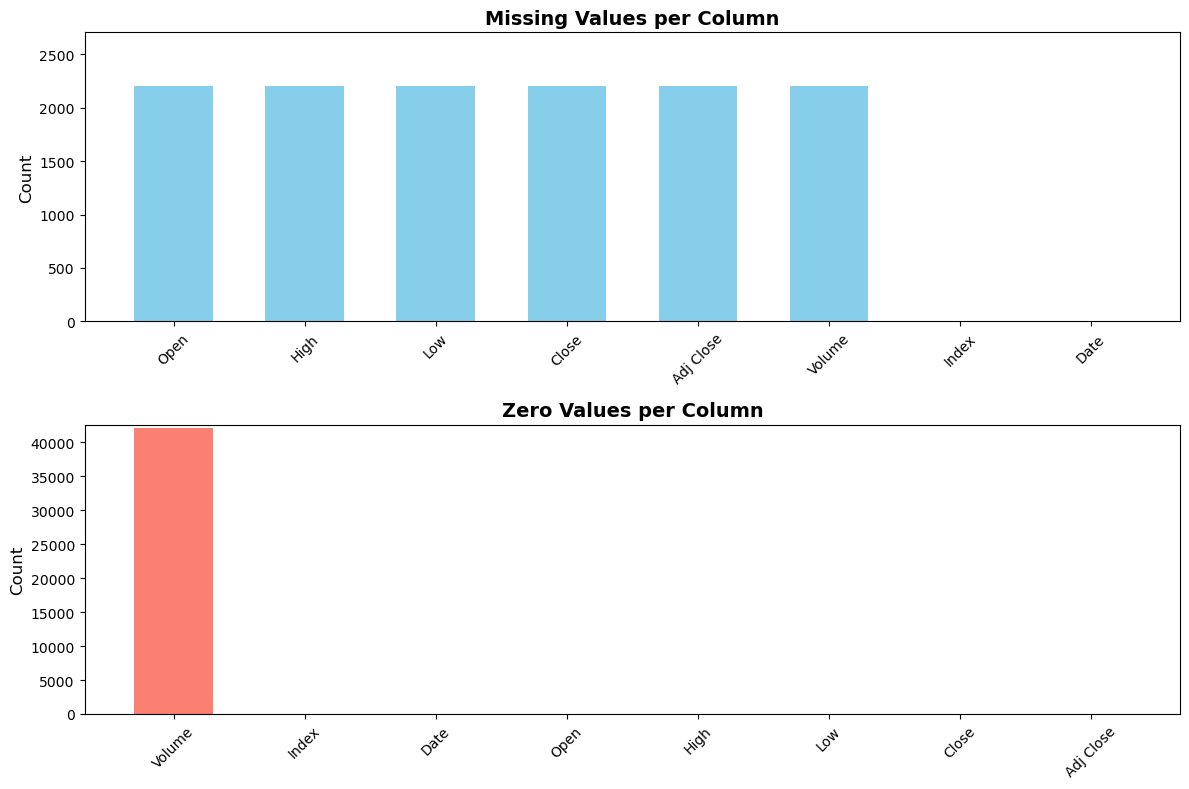

In [22]:
import matplotlib.pyplot as plt

# Create a 2-row figure
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # Adjusted figsize for better proportions
plt.subplots_adjust(hspace=0.4)

# Missing values (NaN)
missing_counts = df.isna().sum().sort_values(ascending=False)
axes[0].bar(missing_counts.index, missing_counts.values, color='skyblue', width=0.6)  # Bar width adjusted
axes[0].set_title('Missing Values per Column', fontsize=14, weight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Zero values
zero_counts = (df == 0).sum().sort_values(ascending=False)
axes[1].bar(zero_counts.index, zero_counts.values, color='salmon', width=0.6)  # Consistent bar width
axes[1].set_title('Zero Values per Column', fontsize=14, weight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Set a consistent y-axis limit if relevant
axes[0].set_ylim(0, missing_counts.max() + 500)  # Add some padding
axes[1].set_ylim(0, zero_counts.max() + 500) 

plt.tight_layout()
plt.show()


## 1.3. Distribution of Open, Close, High, and Low Values

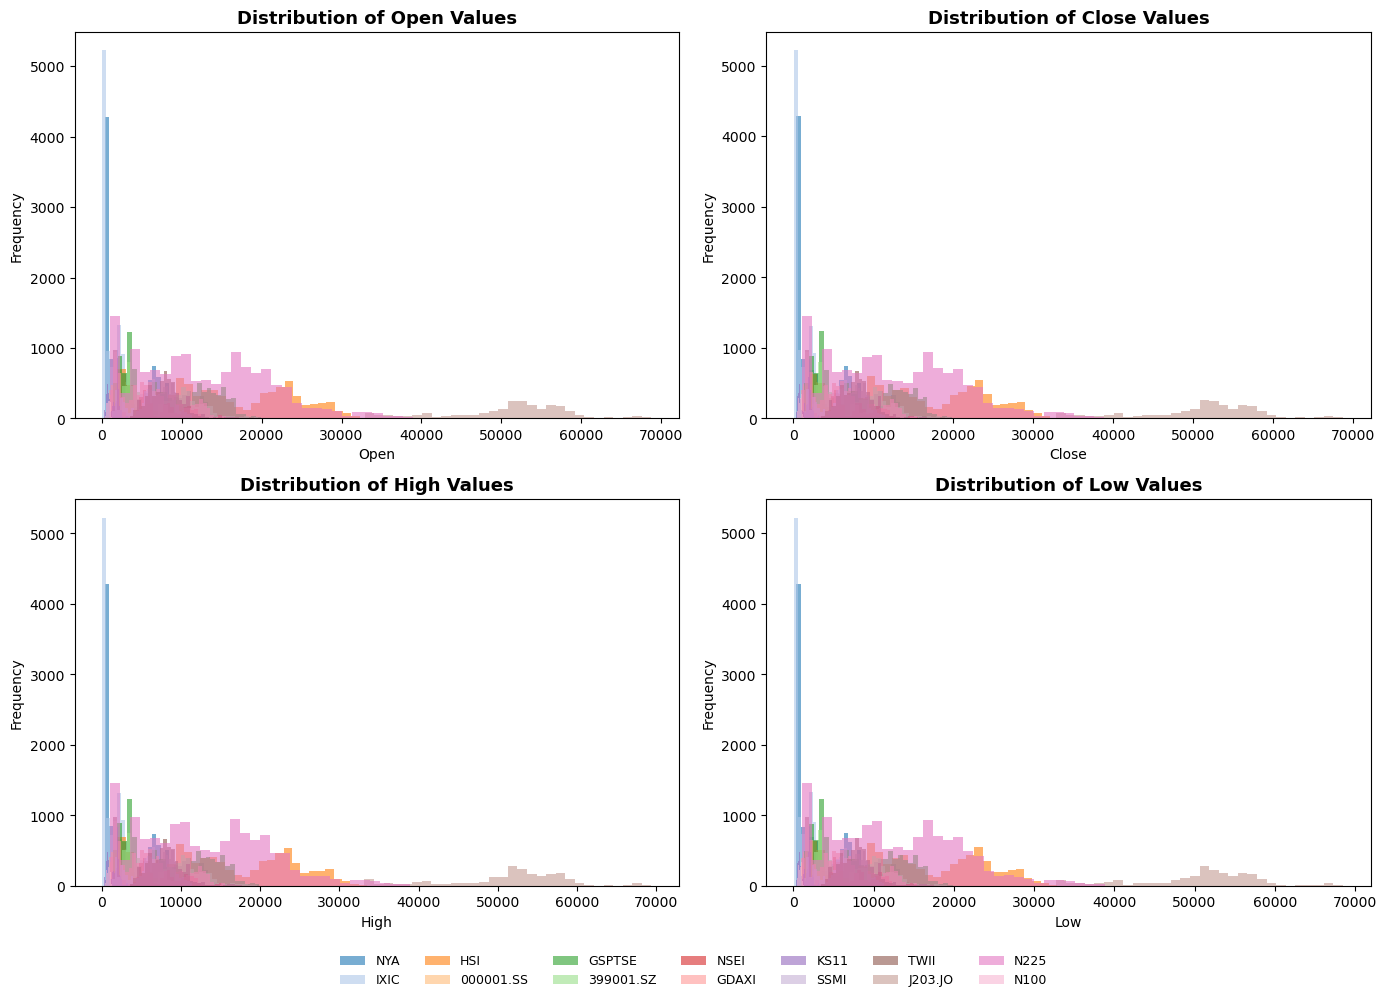

In [23]:
# Visualization Initialization
index_col = 'Index' 
unique_indices = df[index_col].unique()

# Generate a distinct color for each index (14 total)
colors = sns.color_palette("tab20", len(unique_indices))
color_map = dict(zip(unique_indices, colors))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
columns = ['Open', 'Close', 'High', 'Low']

for ax, col in zip(axes, columns):
    for idx in unique_indices:
        subset = df[df[index_col] == idx]
        ax.hist(subset[col].dropna(), bins=30, color=color_map[idx], alpha=0.6, label=idx)
    ax.set_title(f'Distribution of {col} Values', fontsize=13, weight='bold')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Frequency')

# Add a single legend below all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=7, frameon=False, fontsize=9)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # gap to fit legend
plt.show()


## 1.4. Distribution of Volume Values

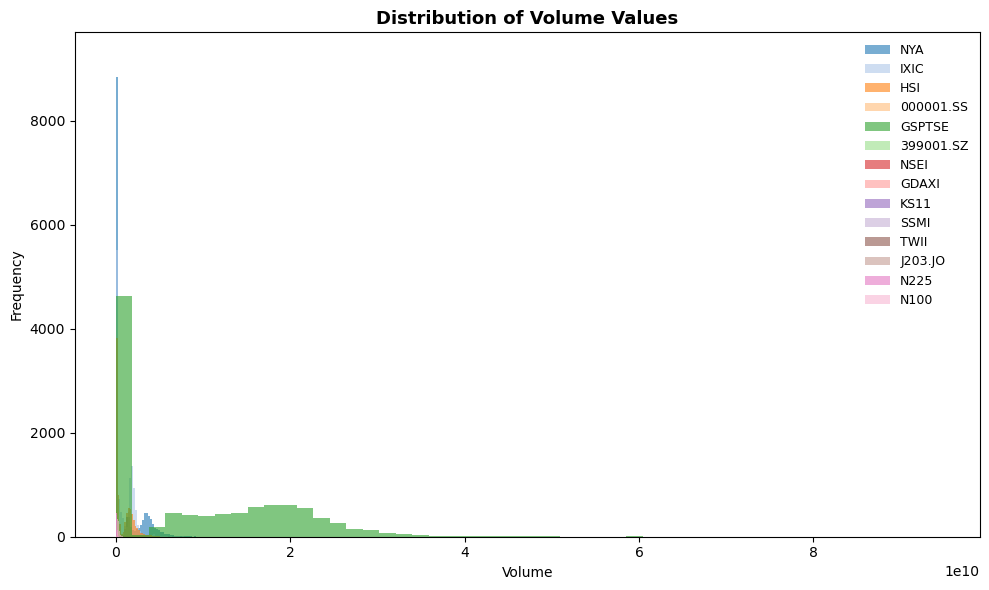

In [24]:
# Visualize Volume distribution separately
plt.figure(figsize=(10, 6))

# Plot Volume distribution for each index
for idx in unique_indices:
    subset = df[df[index_col] == idx]
    plt.hist(subset['Volume'].dropna(), bins=50, color=color_map[idx], alpha=0.6, label=idx)
plt.title('Distribution of Volume Values', fontsize=13, weight='bold')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend(loc='upper right', frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

In [25]:
# Summary for Zero Volume
zero_volume = df[df['Volume'] == 0]
print(f'Total records with zero Volume: {len(zero_volume)}','\n')

# Summary for Zero Volume per Index
zero_volume_per_index = zero_volume[index_col].value_counts()
print("Zero Volume per Index:")
print(zero_volume_per_index)


Total records with zero Volume: 42093 

Zero Volume per Index:
Index
N225         9239
NYA          8832
HSI          3602
IXIC         3457
SSMI         3039
GDAXI        2974
J203.JO      2346
N100         1657
399001.SZ    1570
000001.SS    1361
TWII         1353
GSPTSE       1343
NSEI         1320
Name: count, dtype: int64


# 2. Model Training & Evaluation

## 2.1 Initializing

In [26]:
# Prepare data using DataPrep component
prep = DataPrep(file_path='../data/indexData.csv')
df_eng, features = prep.prepare(stock_index_pattern='Euronext')

# Setup time-series split (reused across all trainers)
ts_split = TimeSeriesSplit(test_size=0.2)

Loading data from ../data/indexData.csv...
Found 3817 rows for Euronext
Selected 14 features: ['pct_change', 'sma_5', 'sma_20', 'ema_5', 'ema_20', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'lag_1', 'lag_2', 'lag_3', 'dow', 'month']
Dataset size: 3797, Classes: 2, Positive: 2022


In [27]:
# Define numerical and categorical features for Decision Tree
numeric_features = [
    'pct_change','sma_5','sma_20','ema_5','ema_20','rsi',
    'macd','macd_signal','macd_hist','lag_1','lag_2','lag_3'
]
categorical_features = ['dow', 'month']

available_numeric = [f for f in numeric_features if f in df_eng.columns]
available_categorical = [f for f in categorical_features if f in df_eng.columns]

dt_features = available_numeric + available_categorical

print(f"Numerical Features: {available_numeric}\n")
print(f"Categorical Features: {available_categorical}\n")

Numerical Features: ['pct_change', 'sma_5', 'sma_20', 'ema_5', 'ema_20', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'lag_1', 'lag_2', 'lag_3']

Categorical Features: ['dow', 'month']



## 2.2. Logisitic Regression

In [28]:
# Train LogisticRegression model using the trainer component
trainer_lr = LogisticTrainer(features=features, numeric_features=numeric_features, categorical_features=categorical_features, solver='liblinear')
X_train, X_test, y_train, y_test = trainer_lr.prepare_data(df_eng, ts_split)
trainer_lr.fit(X_train, y_train)

In [29]:
# Evaluate model
y_pred_lr = trainer_lr.predict(X_test)
metrics = trainer_lr.evaluate(X_test, y_test)
print(f'Accuracy: {metrics["accuracy"]:.4f}')
print('Classification report:\n', metrics['classification_report'])
print('Confusion matrix:\n', metrics['confusion_matrix'])
if metrics['roc_auc'] is not None:
    print(f'ROC AUC: {metrics["roc_auc"]:.4f}')

# Save model
trainer_lr.save(str(Path('..') / 'models' / 'logistic_model_euronext.pkl'))
print(f'Model saved to models/logistic_model_euronext.pkl')


Accuracy: 0.5368
Classification report:
               precision    recall  f1-score   support

           0     0.4703    0.2794    0.3506       340
           1     0.5609    0.7452    0.6401       420

    accuracy                         0.5368       760
   macro avg     0.5156    0.5123    0.4953       760
weighted avg     0.5204    0.5368    0.5106       760

Confusion matrix:
 [[ 95 245]
 [107 313]]
ROC AUC: 0.5226
Model saved to models/logistic_model_euronext.pkl


## 2.3. KNN

In [30]:
# KNN model using the trainer component
trainer_knn = KNNTrainer(features=features, numeric_features=numeric_features, categorical_features=categorical_features, n_neighbors=5)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = trainer_knn.prepare_data(df_eng, ts_split)
trainer_knn.fit(X_train_knn, y_train_knn)

In [31]:
# Evaluate KNN model
y_pred_knn = trainer_knn.predict(X_test_knn)
metrics_knn = trainer_knn.evaluate(X_test_knn, y_test_knn)
print('Accuracy:', round(metrics_knn['accuracy'], 4))
print('Classification report:\n', metrics_knn['classification_report'])
print('Confusion matrix:\n', metrics_knn['confusion_matrix'])

# Save model
trainer_knn.save(str(Path('..') / 'models' / 'knn_model_euronext.pkl'))
print(f'Model saved to models/knn_model_euronext.pkl')


Accuracy: 0.4816
Classification report:
               precision    recall  f1-score   support

           0     0.4297    0.4853    0.4558       340
           1     0.5346    0.4786    0.5050       420

    accuracy                         0.4816       760
   macro avg     0.4821    0.4819    0.4804       760
weighted avg     0.4877    0.4816    0.4830       760

Confusion matrix:
 [[165 175]
 [219 201]]
Model saved to models/knn_model_euronext.pkl


## 2.4. Decision Tree

In [32]:
# Decision Tree model using the trainer component
trainer_dt = DecisionTreeTrainer(
    features=dt_features,
    numeric_features=available_numeric,
    categorical_features=available_categorical,
    max_depth=10
)
X_train_dt, X_test_dt, y_train_dt, y_test_dt = trainer_dt.prepare_data(df_eng, ts_split)
trainer_dt.fit(X_train_dt, y_train_dt)

In [33]:
# Evaluate Decision Tree model
y_pred_dt = trainer_dt.predict(X_test_dt)
metrics_dt = trainer_dt.evaluate(X_test_dt, y_test_dt)
print('Accuracy:', round(metrics_dt['accuracy'], 4))
print('Classification report:\n', metrics_dt['classification_report'])
print('Confusion matrix:\n', metrics_dt['confusion_matrix'])

# Save model
trainer_dt.save(str(Path('..') / 'models' / 'decision_tree_model_euronext.pkl'))
print(f'Model saved to models/decision_tree_model_euronext.pkl')


Accuracy: 0.4658
Classification report:
               precision    recall  f1-score   support

           0     0.4218    0.5235    0.4672       340
           1     0.5207    0.4190    0.4644       420

    accuracy                         0.4658       760
   macro avg     0.4713    0.4713    0.4658       760
weighted avg     0.4765    0.4658    0.4656       760

Confusion matrix:
 [[178 162]
 [244 176]]
Model saved to models/decision_tree_model_euronext.pkl


## 2.5. XGBoost

In [34]:
# XGBoost model using the trainer component
trainer_xgb = XGBTrainer(features=features, numeric_features=numeric_features, categorical_features=categorical_features, n_estimators=100, max_depth=6, learning_rate=0.1)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = trainer_xgb.prepare_data(df_eng, ts_split)
trainer_xgb.fit(X_train_xgb, y_train_xgb)

In [35]:
# Evaluate XGBoost model
y_pred_xgb = trainer_xgb.predict(X_test_xgb)
metrics_xgb = trainer_xgb.evaluate(X_test_xgb, y_test_xgb)
print('Accuracy:', round(metrics_xgb['accuracy'], 4))
print('Classification report:\n', metrics_xgb['classification_report'])
print('Confusion matrix:\n', metrics_xgb['confusion_matrix'])
if metrics_xgb['roc_auc'] is not None:
    print(f'ROC AUC: {metrics_xgb["roc_auc"]:.4f}')

# Save model
trainer_xgb.save(str(Path('..') / 'models' / 'xgb_model_euronext.pkl'))
print(f'Model saved to models/xgb_model_euronext.pkl')


Accuracy: 0.5
Classification report:
               precision    recall  f1-score   support

           0     0.4606    0.6882    0.5519       340
           1     0.5794    0.3476    0.4345       420

    accuracy                         0.5000       760
   macro avg     0.5200    0.5179    0.4932       760
weighted avg     0.5262    0.5000    0.4870       760

Confusion matrix:
 [[234 106]
 [274 146]]
ROC AUC: 0.5206
Model saved to models/xgb_model_euronext.pkl


# 3. Random Classifier Baseline Comparison

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Generate random predictions 
np.random.seed(42)
y_random = np.random.randint(0, 2, size=len(y_test))

# Calculate metrics for random classifier
random_metrics = {
    'Accuracy': accuracy_score(y_test, y_random),
    'Precision': precision_score(y_test, y_random),
    'Recall': recall_score(y_test, y_random),
    'F1-Score': f1_score(y_test, y_random),
    'ROC AUC': roc_auc_score(y_test, y_random) if len(np.unique(y_random)) > 1 else None
}

# Collect all model metrics for comparison 
comparison_data = {
    'Random': random_metrics,
    'Logistic Regression': {
        'Accuracy': metrics['accuracy'],
        'Precision': precision_score(y_test, y_pred_lr),
        'Recall': recall_score(y_test, y_pred_lr),
        'F1-Score': f1_score(y_test, y_pred_lr),
        'ROC AUC': metrics['roc_auc']
    },
    'KNN': {
        'Accuracy': metrics_knn['accuracy'],
        'Precision': precision_score(y_test_knn, y_pred_knn),
        'Recall': recall_score(y_test_knn, y_pred_knn),
        'F1-Score': f1_score(y_test_knn, y_pred_knn),
        'ROC AUC': metrics_knn['roc_auc']
    },
    'Decision Tree': {
        'Accuracy': metrics_dt['accuracy'],
        'Precision': precision_score(y_test_dt, y_pred_dt),
        'Recall': recall_score(y_test_dt, y_pred_dt),
        'F1-Score': f1_score(y_test_dt, y_pred_dt),
        'ROC AUC': metrics_dt['roc_auc']
    },
    'XGBoost': {
        'Accuracy': metrics_xgb['accuracy'],
        'Precision': precision_score(y_test_xgb, y_pred_xgb),
        'Recall': recall_score(y_test_xgb, y_pred_xgb),
        'F1-Score': f1_score(y_test_xgb, y_pred_xgb),
        'ROC AUC': metrics_xgb['roc_auc']
    }
}

# Display comparison as DataFrame
comparison_df = pd.DataFrame(comparison_data).T
print("Model Performance Comparison vs Random Baseline")
print("=" * 70)
print(comparison_df.round(4))
print("\n")

# Calculate improvement over random classifier
print("Improvement Over Random Classifier (ROC AUC %)")
print("=" * 70)
for model in ['Logistic Regression', 'KNN', 'Decision Tree', 'XGBoost']:
    improvement = (comparison_data[model]['ROC AUC'] - comparison_data['Random']['ROC AUC']) * 100
    print(f"{model:20s}: {improvement:+.2f}%")


Model Performance Comparison vs Random Baseline
                     Accuracy  Precision  Recall  F1-Score  ROC AUC
Random                 0.5224     0.5718  0.5405    0.5557   0.5202
Logistic Regression    0.5368     0.5609  0.7452    0.6401   0.5226
KNN                    0.4816     0.5346  0.4786    0.5050   0.4918
Decision Tree          0.4658     0.5207  0.4190    0.4644   0.4744
XGBoost                0.5000     0.5794  0.3476    0.4345   0.5206


Improvement Over Random Classifier (ROC AUC %)
Logistic Regression : +0.24%
KNN                 : -2.85%
Decision Tree       : -4.58%
XGBoost             : +0.03%
